# Ielādējam tokenizer / modeli (LVBERT) caur HuggingFace

In [1]:
from transformers import AutoTokenizer, TFBertForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("AiLab-IMCS-UL/lvbert")
model = TFBertForSequenceClassification.from_pretrained("AiLab-IMCS-UL/lvbert", from_pt=True, num_labels=5)

c:\Users\Devtop\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initia

In [5]:
enc = tokenizer.encode("Šis žagaru saišķis")
dec = tokenizer.decode(enc)
print("Encode: " + str(enc))
print("Decode: " + str(dec))

Encode: [2, 934, 30266, 1055, 14, 91, 12, 4417, 7, 3]
Decode: [CLS] Šis žagaru saišķis [SEP]


# Datu ielāde

In [8]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
df = pd.read_json('5cat_big.json')
df.drop(['title', 'link'], axis=1, inplace=True)
df.head()
sentences=df['body']
le = LabelEncoder().fit(df["category"])
df['encod_cat'] = le.transform(df['category'])
labels=df['encod_cat']
len(sentences),len(labels)

(6525, 6525)

# Tokenizācija

In [9]:
import numpy as np
input_ids=[]
attention_masks=[]

for sent in sentences:
    bert_inp=tokenizer.encode_plus(sent,add_special_tokens = True,max_length =64,pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
labels=np.array(labels)
len(input_ids),len(attention_masks),len(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\Devtop\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


(6525, 6525, 6525)

# Sadalam datus apmacibai/parbaudei

In [10]:
from sklearn.model_selection import train_test_split
apmacibas_ievade,validacijas_ievade,apmacibas_birkas,validacijas_birkas,apmacibas_maskas,validacijas_maskas=train_test_split(input_ids,labels,attention_masks,test_size=0.2)

# Modeļa apmācība

In [12]:
import tensorflow as tf

# Saglabajam labako modeli pec apmacibas zuduma starp epohiem
model_save_path='./models/bert_model.h5'
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,save_weights_only=True,monitor='val_loss',mode='min',save_best_only=True)]

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5,epsilon=1e-08)
model.compile(loss=loss,optimizer=optimizer,metrics=[metric])
print(model.summary())

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110620416 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 110624261 (422.00 MB)
Trainable params: 110624261 (422.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [28]:
history=model.fit([apmacibas_ievade,apmacibas_maskas],apmacibas_birkas,batch_size=32,epochs=5,validation_data=([validacijas_ievade,validacijas_maskas],validacijas_birkas),callbacks=callbacks)

Epoch 1/5
164/164 [==============================] - 720s 4s/step - loss: 0.3306 - accuracy: 0.9056 - val_loss: 0.1614 - val_accuracy: 0.9387
Epoch 2/5
164/164 [==============================] - 689s 4s/step - loss: 0.0769 - accuracy: 0.9787 - val_loss: 0.1059 - val_accuracy: 0.9678
Epoch 3/5
164/164 [==============================] - 696s 4s/step - loss: 0.0287 - accuracy: 0.9929 - val_loss: 0.1650 - val_accuracy: 0.9502
Epoch 4/5
164/164 [==============================] - 709s 4s/step - loss: 0.0212 - accuracy: 0.9933 - val_loss: 0.1364 - val_accuracy: 0.9648
Epoch 5/5
164/164 [==============================] - 760s 5s/step - loss: 0.0102 - accuracy: 0.9975 - val_loss: 0.1616 - val_accuracy: 0.9625


# Ielādējam veiksmīgāko modeli, novērtējam / vizualizējam

41/41 [==============================] - 54s 1s/step
(1305,)
(1305,)
              precision    recall  f1-score   support

           0      0.988     0.992     0.990       248
           1      0.996     1.000     0.998       258
           2      1.000     1.000     1.000       261
           3      0.997     0.991     0.994       319
           4      1.000     1.000     1.000       219

    accuracy                          0.996      1305
   macro avg      0.996     0.997     0.996      1305
weighted avg      0.996     0.996     0.996      1305



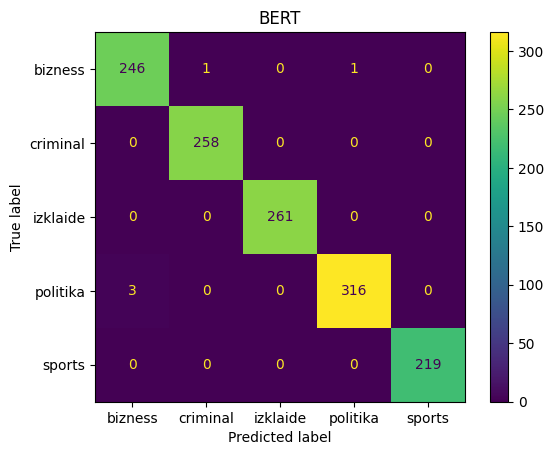

In [29]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#Ieladejam lidz sim veiksmigaka modela svarus
model_load_path='./models/bert_model_0.9755.h5'
model.load_weights(model_load_path)

y_pred = model.predict([validacijas_ievade,validacijas_maskas], batch_size=32)
y_pred = np.argmax(y_pred.logits, axis=1)
print(validacijas_birkas.shape)
print(y_pred.shape)
cm = confusion_matrix(validacijas_birkas, y_pred)
labels = ['bizness', 'criminal', 'izklaide', 'politika', 'sports']
plot = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)
plot.plot()
plot.ax_.set_title("BERT")
print(classification_report(validacijas_birkas, y_pred, digits=3))
clsf_report = pd.DataFrame(classification_report(y_true = validacijas_birkas, y_pred = y_pred, output_dict=True)).transpose()
clsf_report.to_csv('Report BERT.csv', index= True)